# Calculate Metadata

This notebook is used to calculate a variety of descriptive statistics and facts about the corpus. Some insights include songs that span multiple years, covers, most popular song names, top performing artists overall, and top performing artists of each year. 

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import itertools
import json
import pickle
import gensim

In [3]:
# Open everything that's been saved in /data/conditioned

df=pd.read_csv("../../data/conditioned/use-this-master-lyricsdf-extracted.csv")


with open("../../data/conditioned/noun-n-gram.json") as json_file:
    noungram = json.load(json_file)
with open("../../data/conditioned/nounvocab.json") as json_file:
    nounvocab = json.load(json_file)
with open("../../data/conditioned/nounid2word.json") as json_file:
    nounid2word = json.load(json_file)
with open("../../data/conditioned/adj-n-gram.json") as json_file:
    adjgram = json.load(json_file)
with open("../../data/conditioned/adjvocab.json") as json_file:
    adjvocab = json.load(json_file)
with open("../../data/conditioned/adjid2word.json") as json_file:
    adjid2word = json.load(json_file)


f = open("../../data/conditioned/ahypes.p",'r')  
ahypes = pickle.load(f)  
f = open("../../data/conditioned/nhypes.p",'r')  
nhypes = pickle.load(f)
f = open("../../data/conditioned/corpus.p",'r')  
corpus = pickle.load(f)


df.head()

,index,position,year,title.href,title,artist,lyrics,decade,song_key,lyrics_url,lyrics_abstract
0,0,1,1970,https://en.wikipedia.org/wiki/Bridge_over_Trou...,Bridge over Troubled Water,Simon and Garfunkel,When you're weary. Feeling small. When tears a...,1970,1970-1,http://lyrics.wikia.com/Simon_And_Garfunkel:Br...,When you're weary. Feeling small. When tears a...
1,1,2,1970,https://en.wikipedia.org/wiki/(They_Long_to_Be...,(They Long to Be) Close to You,The Carpenters,Why do birds suddenly appear. Everytime you ar...,1970,1970-2,http://lyrics.wikia.com/Carpenters:%28They_Lon...,Why do birds suddenly appear. Everytime you ar...
2,2,3,1970,https://en.wikipedia.org/wiki/American_Woman_(...,American Woman,The Guess Who,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d...",1970,1970-3,http://lyrics.wikia.com/The_Guess_Who:American...,"Mmm, da da da. Mmm, mmm, da da da. Mmm, mmm, d..."
3,3,4,1970,https://en.wikipedia.org/wiki/Raindrops_Keep_F...,Raindrops Keep Fallin' on My Head,B.J. Thomas,Raindrops are falling on my head. And just lik...,1970,1970-4,http://lyrics.wikia.com/B.J._Thomas:Raindrops_...,Raindrops are falling on my head. And just lik...
4,4,5,1970,https://en.wikipedia.org/wiki/War_(Edwin_Starr...,War,Edwin Starr,"War, huh, yeah. What is it good for? Absolutel...",1970,1970-5,http://lyrics.wikia.com/Edwin_Starr:War,"War, huh, yeah. What is it good for? Absolutel..."


# Initial invesigation of Most Popular artists
These counts include songs that may appear more than once because they were in multiple year end charts.

In [4]:
artist_appearance_counts = df.artist.value_counts()
artist_appearance_counts_norm = df.artist.value_counts(normalize=True)
unique_artists = df.artist.unique()

artist_appearance_counts

Madonna                       36
Mariah Carey                  30
Rihanna                       27
Elton John                    27
Michael Jackson               26
Janet Jackson                 23
Usher                         22
Whitney Houston               22
R. Kelly                      18
Stevie Wonder                 18
Pink                          18
beyonce                       17
Katy Perry                    17
Chris Brown                   17
Kelly Clarkson                16
Eminem                        16
Britney Spears                16
The Black Eyed Peas           16
Jay-Z                         15
Chicago                       15
Taylor Swift                  15
Prince                        15
Ludacris                      14
Rod Stewart                   14
Maroon 5                      14
Phil Collins                  14
Diana Ross                    13
Olivia Newton-John            13
Kenny Rogers                  13
Lady Gaga                     13
          

In [6]:
# Songs that appear more than once
song_occurrences = df.groupby('title')
song_occurrences_over_1 = song_occurrences.filter(lambda x: len(x) > 1)
duplicate_song_groups = song_occurrences_over_1.groupby('title').groups

In [7]:
len(song_occurrences.groups), len(duplicate_song_groups)

(4059, 371)

# Create basic breakdowns of the data set
The counts enable further insights about naming, covers, and multiyear songs

In [62]:
#song_occurrences_over_1[song_occurrences_over_1['title']=='Shake It Off']
OCCUR_TYPE_MUTLIYEAR = 'multiyear' # Same song, appears on multiple years
OCCUR_TYPE_DUP_NAME = 'duplicateName' # Same name, different song
OCCUR_TYPE_COVER = 'cover' # Same song content, different artist

def check_dups_covers(row, rows, mode, vals):    
    # For all songs, after the first song, check against the others to determine if it is likely a
    # cover, a duplicate, or just an identically named song.
    if len(rows) >= 1:
        for check_row in rows:
            #print row.title
            
            if not (row.title in vals):
                #print 'Adding list'
                vals[row.title] = []
            
            # Check duplicate
            if mode == OCCUR_TYPE_MUTLIYEAR and check_row['row'].artist.lower() == row.artist.lower():
                check_row['isMultiyear'] = True
                vals[row.title].append({
                        row['index']: row, 
                        check_row['row']['index']: check_row['row']
                    })

            # Check if cover
            # TODO: Use simularity calculation? Match common substrings?
            elif (mode == OCCUR_TYPE_COVER and 
                  check_row['row'].artist.lower() != row.artist.lower() and 
                  (check_row['row'].lyrics[0:25] == row.lyrics[0:25])): # or
                   #check_row['row']['title.href'] == row['title.href'])):
                check_row['isCover'] = True
                #print '\t ***Cover*** %s, %s' % (check_row['row'].artist, row.artist)
                vals[row.title].append({
                        row['index']: row, 
                        check_row['row']['index']: check_row['row']
                    })
                
            elif (mode == OCCUR_TYPE_DUP_NAME and 
                  check_row['row'].artist.lower() != row.artist.lower() and 
                  check_row['row'].lyrics[0:25] != row.lyrics[0:25]):
                #print '\t Same name, different song'
                vals[row.title].append({
                        row['index']: row, 
                        check_row['row']['index']: check_row['row']
                    })

def check_song_occurrences(grp, mode):
    vals = {}
    
    # Loop over all songs with the same name
    for title in grp:
        #print '"%s"' % title
        rows = []

        # Process individual song instances and determine if the song is the same song appearing multiple times,
        # if the song is a cover, or if the songs just happen to share the same name.
        for idx in grp[title]:
            row = df.iloc[idx]

            # Set lyrics to an empty string to avoid float issues on empty lyrics 
            if not isinstance(row.lyrics, basestring): # or len(row.lyrics) < 25:
                row.lyrics = ''

            # Check current row against previous rows in groups
            check_dups_covers(row, rows, mode, vals)

            # Append row for future comparison
            rows.append({
                    'isDuplicate': False, # multiyear (most likely back-to-back years)
                    'isCover': False,
                    'row': row
                })
        
    vals_trimmed = {}
    for k in vals:
        v = vals[k]
        if (len(v) > 0):
            vals_trimmed[k] = v
                    
    print '%s: %d results' % (mode, len(vals_trimmed))
    
    return vals_trimmed
            
cso_multiyear = check_song_occurrences(duplicate_song_groups, OCCUR_TYPE_MUTLIYEAR)
cso_cover = check_song_occurrences(duplicate_song_groups, OCCUR_TYPE_COVER)
cso_dup_name = check_song_occurrences(duplicate_song_groups, OCCUR_TYPE_DUP_NAME)

multiyear: 194 results
cover: 16 results
duplicateName: 188 results


# Count song name occurrences

In [9]:
#duplicate_song_groups[duplicate_song_groups.keys()[0]]
#len(cso_.keys())

# TODO: Account for multiyears in duplicates
def most_freq_song_name():
    counts = {}
    
    for k in cso_dup_name:
        counts[k] = len(cso_dup_name[k])
        print "%s: %d" % (k, counts[k]) 
    
most_freq_song_name()

Come and Get Your Love: 1
No Time: 1
Misery: 1
Sunshine: 1
I Can See Clearly Now: 1
Sukiyaki: 1
Everybody Plays the Fool: 1
Never Can Say Goodbye: 1
You and Me: 2
Diamonds: 2
Smile: 1
TRUE: 1
Happy: 1
What's My Name?: 1
Hero: 5
Rock On: 1
Head over Heels: 1
My Boo: 2
Burn: 1
Oh Girl: 1
Too Close: 1
Heartbreaker: 3
Sing: 1
Lay Your Hands on Me: 1
Believe: 1
Magic: 6
Anything: 3
Someday: 6
The Power of Love: 1
Always on My Mind: 1
Bad: 1
Lean on Me: 1
Life Is a Highway: 1
Venus: 1
Scream: 1
Incomplete: 1
My Love: 5
Love Like This: 1
Don't Be Cruel: 1
Rich Girl: 1
Angel: 15
Suddenly: 1
Lady: 6
Please Don't Go: 3
Shake It: 1
Say Something: 1
I Want You: 1
Wonderful: 1
Mockingbird: 1
Bottoms Up: 2
Turn the Beat Around: 1
Miss You: 1
Shake It Off: 1
Again: 2
I Wanna Love You: 1
When I'm Gone: 1
Photograph: 2
I Miss You: 3
Stay: 3
Heaven: 10
You and I: 3
Count On Me: 1
Shining Star: 1
Without You: 5
Fire: 1
Slow Motion: 1
Music: 1
If: 1
Masterpiece: 1
Feel Like Makin' Love: 1
Baby: 3
Sweet Lo

In [10]:
cso_dup_name['Crazy']

[{2174: index                                                           2174
  position                                                          75
  year                                                            1991
  title.href           https://en.wikipedia.org/wiki/Crazy_(Seal_song)
  title                                                          Crazy
  artist                                                          Seal
  lyrics             In a church by the face. He talks about the pe...
  decade                                                          1990
  song_key                                                     1991-75
  lyrics_url                        http://lyrics.wikia.com/Seal:Crazy
  lyrics_abstract    In a church by the face. He talks about the pe...
  Name: 2174, dtype: object,
  2467: index                                                           2467
  position                                                          68
  year                              

# Count of the songs that are obviously covers/remakes

In [11]:
def most_freq_cover_song():
    counts = {}
    
    for k in cso_cover:
        counts[k] = len(cso_cover[k][0])
        print "%s: %d" % (k, counts[k]) 
        
most_freq_cover_song()

Best of My Love: 2
I Still Believe: 2
Endless Love: 2
I Don't Want to Miss a Thing: 2
Don't Let the Sun Go Down on Me: 2
How Am I Supposed to Live Without You: 2
Cruel Summer: 2
Drift Away: 2
Stand by Me: 2
All by Myself: 2
Don't Tell Me: 2
Hard to Say I'm Sorry: 2
Listen to Your Heart: 2
I'll Be There: 2
Dejà Vu: 2
Love Shack: 2


In [12]:
def most_freq_multiyear_songs():
    counts = {}
    
    for k in cso_multiyear:
        counts[k] = len(cso_multiyear[k][0])
        print "%s: %d" % (k, counts[k]) 
        
        

def dedup_df():
    songs_to_drop = []
    
    for songname in cso_multiyear:
        drop_candidate = None
        
        for idx in cso_multiyear[songname][0]:
            check_item = cso_multiyear[songname][0][idx]
            
            # Set a drop candidate when the position is higher (because lower is a better rank)
            if (drop_candidate is None or 
                drop_candidate.position > check_item.position):
                drop_candidate = check_item
        
#         print drop_candidate['index']
#         print dir(drop_candidate)
        songs_to_drop.append(drop_candidate['index'])
        
    df_drop = df.drop(songs_to_drop)
    
    return df_drop
    
#most_freq_multiyear_songs()
df_drop = dedup_df()

Take away for output of `most_freq_multiyear_songs` is that no songs appeared on more than two consecutive years.

In [13]:
df_drop.shape, df.shape

((4306, 11), (4500, 11))

# Prepare a series of artist counts
Generates some insights about our song and artist data.

In [14]:
len(cso_multiyear)

194

In [15]:
artists_only_once = len(artist_appearance_counts[artist_appearance_counts.values == 1])
artists_multiple = len(artist_appearance_counts[artist_appearance_counts.values > 1])

print "Unique Artists %d, Artists only appearing once %d, Artists appearing many times %d" % (len(unique_artists), artists_only_once, artists_multiple)

Unique Artists 1761, Artists only appearing once 977, Artists appearing many times 783


In [16]:
artist_appearance_dedup_counts = df_drop.artist.value_counts()
artist_appearance_dedup_counts

Madonna                       35
Mariah Carey                  28
Elton John                    27
Michael Jackson               26
Rihanna                       23
Janet Jackson                 21
Whitney Houston               21
Usher                         20
Stevie Wonder                 18
R. Kelly                      17
Pink                          16
Chris Brown                   15
Chicago                       15
Eminem                        15
beyonce                       15
Prince                        15
Katy Perry                    14
Kelly Clarkson                14
Rod Stewart                   14
The Black Eyed Peas           14
Jay-Z                         14
Britney Spears                14
Phil Collins                  14
Diana Ross                    13
Olivia Newton-John            13
Kenny Rogers                  13
Ludacris                      12
Lionel Richie                 12
Bryan Adams                   12
George Michael                12
          

# Illustrate the distribution of artists and the number of unique songs 
Shows the comparison of prolifict artists versus "one hit wonders" (though this is year end data so it is not enough data to call them true one hit wonders).

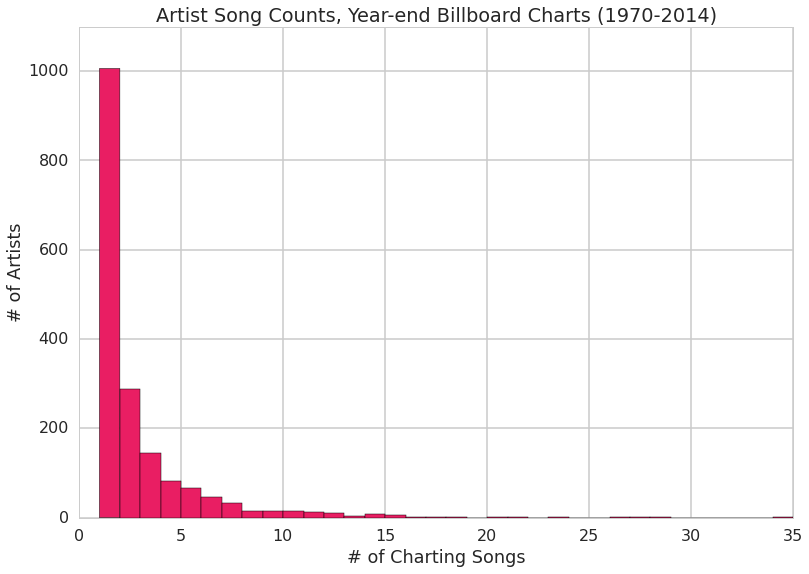

In [51]:
fig = plt.figure()
fig.patch.set_alpha(0.1)
plt.hist(artist_appearance_dedup_counts, 34, facecolor='#E91E63')
plt.xlabel('# of Charting Songs')
plt.ylabel('# of Artists')
plt.title('Artist Song Counts, Year-end Billboard Charts (1970-2014)')
plt.axis([0, 35, 0, 1100])
#plt.grid(True)
plt.savefig('artists_with_songs.png', transparent=True)

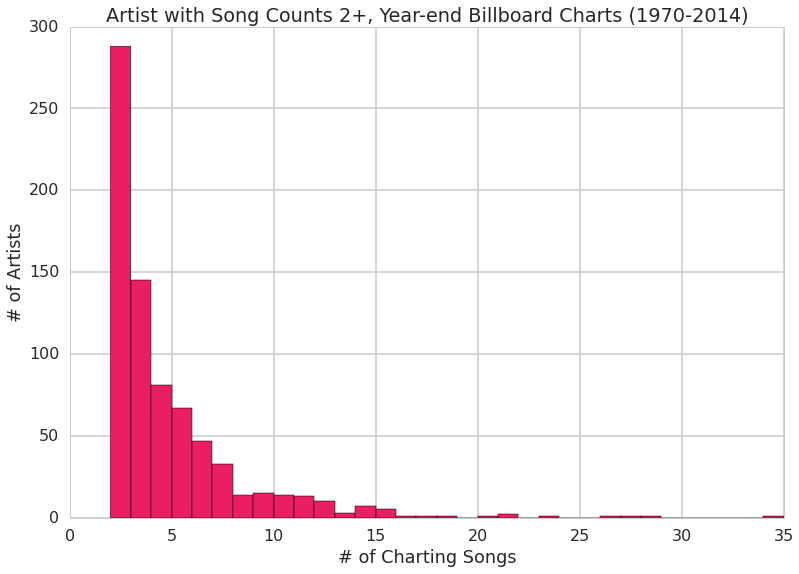

In [54]:
artist_2plus_mask = (artist_appearance_dedup_counts >= 2)
artist_2plus = artist_appearance_dedup_counts[artist_2plus_mask]
#artist_2plus
plt.hist(artist_2plus, 33, facecolor='#E91E63')
plt.xlabel('# of Charting Songs')
plt.ylabel('# of Artists')
plt.title('Artist with Song Counts 2+, Year-end Billboard Charts (1970-2014)')
plt.savefig('artists_with_songs_over2.png', transparent=True)

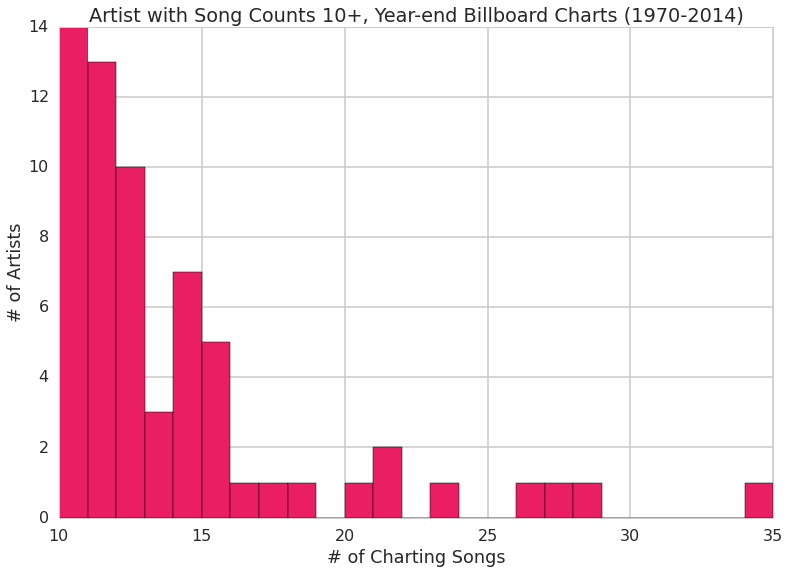

In [55]:
artist_10plus_mask = (artist_appearance_dedup_counts >= 10)
artist_10plus = artist_appearance_dedup_counts[artist_10plus_mask]
#artist_10plus
plt.hist(artist_10plus, 25, facecolor='#E91E63')
plt.xlabel('# of Charting Songs')
plt.ylabel('# of Artists')
plt.title('Artist with Song Counts 10+, Year-end Billboard Charts (1970-2014)')
plt.savefig('artists_with_songs_over10.png', transparent=True)

# Prepare counts of artists top songs for each year
This will be the data that powers our interactive chart on the website.

In [50]:
df_drop.head()

dict_year_artists_song_count = {}
year_artists_song_count = []
df_year_artists_song_count = None

# Extract Artist, Year, and count of songs 
year_perf_grp = df_drop.groupby(['year', 'artist'])
year_perf_grp.groups

for year_artist_tuple in year_perf_grp.groups:
    year, artist = year_artist_tuple
    songs = year_perf_grp.groups[year_artist_tuple]
    count = len(songs)
    
    if not (year in dict_year_artists_song_count):
        dict_year_artists_song_count[year] = {}
        
    dict_year_artists_song_count[year][artist] = count
    year_artists_song_count.append({
            'year': year,
            'artist': artist,
            'count': count
        })

    df_year_artists_song_count = pd.DataFrame(year_artists_song_count)
    
import json
with open('year_artist_song_count.json', 'w') as fp:
    json.dump(dict_year_artists_song_count, fp)
    
df_year_artists_song_count.to_csv('year_artist_song_count.csv', encoding='utf-8')

# Find the most popular artist in each year

In [45]:
def most_popular_artist_year():
    d = dict_year_artists_song_count
    most_pop = {}
    
    for year in d:
        most_count = 0
        most_artist = ''

        for artist in d[year]:
            if (d[year][artist] > most_count):
                most_count = d[year][artist]
                most_artist = artist
        
        most_pop[year] = (most_artist, most_count)
        print '%d -- %s: %d' % (year, most_artist, most_count)

most_popular_artist_year()

1970 -- The Jackson 5: 4
1971 -- The Carpenters: 3
1972 -- Al Green: 3
1973 -- War: 3
1974 -- Paul McCartney and Wings: 3
1975 -- Elton John: 3
1976 -- Bee Gees: 2
1977 -- Leo Sayer: 3
1978 -- Andy Gibb: 3
1979 -- Donna Summer: 4
1980 -- Eagles: 3
1981 -- Diana Ross: 3
1982 -- Daryl Hall and John Oates: 3
1983 -- Michael Jackson: 5
1984 -- Lionel Richie: 4
1985 -- Madonna: 5
1986 -- Lionel Richie: 3
1987 -- Madonna: 4
1988 -- George Michael: 5
1989 -- Bobby Brown: 5
1990 -- Janet Jackson: 5
1991 -- C+C Music Factory: 3
1992 -- Amy Grant: 3
1993 -- Shai: 3
1994 -- Babyface: 3
1995 -- Boyz II Men: 4
1996 -- LL Cool J: 3
1997 -- Spice Girls: 3
1998 -- Next: 3
1999 -- Whitney Houston: 4
2000 -- Destiny's Child: 3
2001 -- Jennifer Lopez: 3
2002 -- Pink: 3
2003 -- 50 Cent: 4
2004 -- Alicia Keys: 3
2005 -- 50 Cent: 4
2006 -- Pussycat Dolls: 3
2007 -- Justin Timberlake: 4
2008 -- Lil Wayne: 4
2009 -- beyonce: 4
2010 -- The Black Eyed Peas: 4
2011 -- Katy Perry: 4
2012 -- Rihanna: 4
2013 -- Bru

# Number of artists only appearing once

In [59]:
len(artist_appearance_dedup_counts[artist_appearance_dedup_counts == 1])

1006

# Number of unique artists

In [60]:
len(artist_appearance_dedup_counts)

1759